<a href="https://colab.research.google.com/github/mmatera/Spin-Chains-/blob/main/HS_projected_evolution_debugged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip
!pip install scipy
!pip install matplotlib.inline
!pip install numpy
!pip install networkx
!pip install Cython

In [1]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import math, cmath
import proj_ev_tools as me

from IPython.display import display, Math, Latex

In [2]:
N = 2          # número de spines

h  = 1.0 * 2 * np.pi * np.ones(N) 
Jx = 0.15 * 2 * np.pi * np.ones(N)
Jy = 0.25 * 2 * np.pi * np.ones(N)
Jz = 0.1 * 2 * np.pi * np.ones(N)

In [3]:
### Operadores de spin y hamiltoniano

## solo 1-operadores
globalid_list, sx_list, sy_list, sz_list = me.one_body_spin_ops(N)
pauli_vec = [sx_list, sy_list, sz_list]

## upto 2-opeadores ie. armé una lista de listas, con 1-operadores y 2-operadores 
## pero todos actuando sobre el espacio de Hilbert global 2^N dimensional H = \otimes_{j}^{N} h_j 
two_body_spin_list = me.all_two_body_spin_ops(N)

## Hamiltoniano 
H_H = me.Heisenberg_hamiltonian(N, Jx, Jy, Jz, h)
#qutip.hinton(rho=H_H, title = "Heisenberg's hamiltonian Hinton diagram")

### Free particle-Operators en términos de los operadores de spin
x_op, p_op, comm_xp, corr_xp, p_dot = me.free_particle_ops(N, H_H, sz_list)

## un test automatizado sobre las bases
me.basis_defs_test(N)

OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True


In [57]:
HS_modified = True

class Result(object):
      def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

def callback(t, rhot):
    global rho
    rho = rhot

def projected_evolution(author=True,x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, 
                        gaussian=False, gr = 1, deltat=10., tmax = 500., distance=me.bures, 
                        do_project=True):
    global rho
    loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    if (gaussian and gr == 1):
        coeffs_me1_gr1 = [[10**-18,10**-18],[10**-4,10**-4],
                          [10**-3,10**-3],[np.pi*10**-9,np.pi*10**-9]]
        rho0 = me.initial_state(N, gaussian, gr, None, coeffs_me1_gr1, None)
        
    elif(gaussian and gr == 2):
        a = len(me.all_two_body_spin_ops(N))
        b = len(me.all_two_body_spin_ops(N)[0])

        coeffs_me2_gr2 = 10**-2 * np.full((a,b),1.)
        rho0 = me.initial_state(N, gaussian, gr, None, coeffs_me2_gr2, None)
             
    elif(not gaussian):
        rho0 = me.initial_state(N, gaussian, None, x, None, psi0)
         
    if (author):
        basis = me.base_orth(me.n_body_basis(N,2), rho0)
                             #rho0)  ## // Á la Tom
    else: 
        lista_ampliada = []
        for i in range(len(me.n_body_basis(N,1))):
            lista_ampliada.append(qutip.tensor(me.n_body_basis(N,1)[i], qutip.qeye(2)))
        basis = me.base_orth(lista_ampliada, rho0) ## // Á la Mauricio
        
    obs = [x_op, p_op, comm_xp, corr_xp]
          #, x_op**2,p_op**2, corr_op, p_dot]
        
    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    c_op_list = me.spin_dephasing(N,gamma)
    rho = rho0                                                               ## // Á la Mauricio
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=H_H, 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               c_ops=c_op_list, 
                               e_ops=callback,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
            rho = me.proj_op(me.logM(rho), basis, rho0)
            #rho = me.proj_op(me.logM(rho), basis, loc_globalid)
            e0 = max(rho.eigenenergies())
            rho = rho - loc_globalid * e0
            rho = rho.expm()
            trrho = (2.*rho.tr())
            rho = (rho+rho.dag())/trrho

        #print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = np.array(approx_exp_vals)
    
    title = f" BW Dinámica cerrada no gaussiana wb1={omega_1} wb2={omega_2}" 
    if do_project:
        title = title + "_projected_"

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return result

In [56]:
coeffs_me1_gr1 = [[10**-18,10**-18],[10**-4,10**-4],
                          [10**-3,10**-3],[np.pi*10**-9,np.pi*10**-9]]
rho_me10 = me.initial_state(N, True, 1, None, coeffs_me1_gr1, None)
loc_globalid = qutip.tensor(qutip.qeye(2), qutip.qeye(2))

basis = me.base_orth(me.n_body_basis(N,2), rho_me10)

A = me.proj_op(me.logM(rho_me10), basis, rho_me10)
A

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-1.38629461e+00+0.j      5.00000000e-05-0.0005j  5.00000000e-05-0.0005j
   0.00000000e+00+0.j    ]
 [ 5.00000000e-05+0.0005j -1.38629461e+00+0.j      0.00000000e+00+0.j
   5.00000000e-05-0.0005j]
 [ 5.00000000e-05+0.0005j  0.00000000e+00+0.j     -1.38629461e+00+0.j
   5.00000000e-05-0.0005j]
 [ 0.00000000e+00+0.j      5.00000000e-05+0.0005j  5.00000000e-05+0.0005j
  -1.38629462e+00+0.j    ]]

sampling: 30
sampling: 30


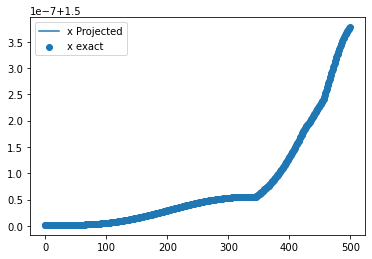

In [58]:
## usando n_body_basis(2) y el estado no gaussiano de Mauricio

results = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()

sampling: 30
sampling: 30


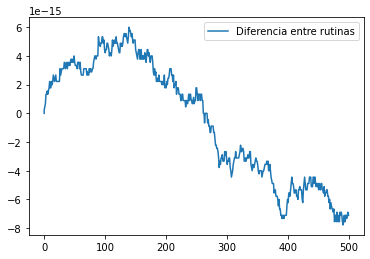

In [5]:
results1 = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=True)
results2 = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=False)

plt.plot(results1["ts"], results1["averages"][:,0] - results2["averages"][:,0], label="Diferencia entre rutinas")
plt.legend()

sampling: 30
sampling: 30


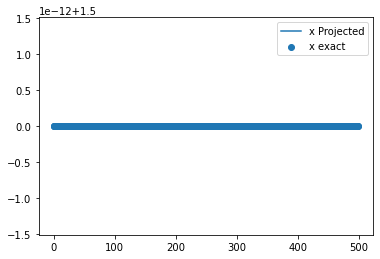

In [6]:
## usando n_body_basis(2) y el estado no gaussiano de Mauricio

results = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()

sampling: 30
sampling: 30


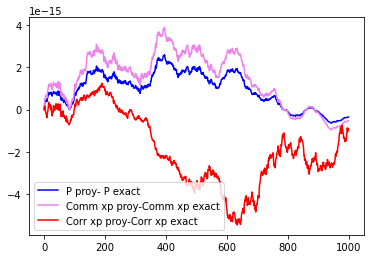

In [14]:
resultsA = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 1000, 
                              distance=me.bures, do_project=True)


resultsB = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 1000, 
                              distance=me.bures, do_project=False)


plt.plot(results["ts"], resultsA["averages"][:,1]-resultsB["averages"][:,1],
                                                label="P proy- P exact", color="blue")

plt.plot(results["ts"], resultsA["averages"][:,2]-resultsB["averages"][:,2],
                                                label="Comm xp proy-Comm xp exact", color="violet")


plt.plot(results["ts"], resultsA["averages"][:,3]-resultsB["averages"][:,3],
                                                label="Corr xp proy-Corr xp exact", color="red")
plt.legend()

sampling: 30
sampling: 30


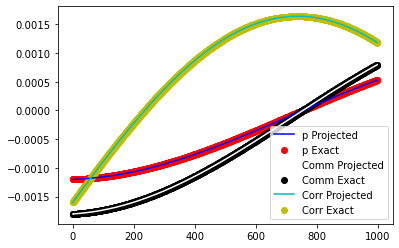

In [18]:
resultsA = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 1000, 
                              distance=me.bures, do_project=True)


resultsB = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 1000, 
                              distance=me.bures, do_project=False)


plt.plot(resultsA["ts"], resultsA["averages"][:,1], label="p Projected", color="b")
plt.scatter(resultsB["ts"], resultsB["averages"][:,1], label="p Exact", color="r")

plt.plot(resultsA["ts"], resultsA["averages"][:,2], label="Comm Projected", color="white")
plt.scatter(resultsB["ts"], resultsB["averages"][:,2], label="Comm Exact", color="black")

plt.plot(resultsA["ts"], resultsA["averages"][:,3], label="Corr Projected", color="c")
plt.scatter(resultsB["ts"], resultsB["averages"][:,3], label="Corr Exact", color="y")

plt.legend()

sampling: 120


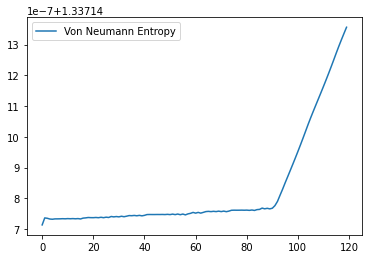

In [128]:
results = projected_evolution(author = True, x=None, gamma = 5*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=4, tmax = 5, 
                              distance=me.bures, do_project=False)

plt.plot(results, label="Von Neumann Entropy")
plt.legend()

In [132]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.7.0
Numpy,1.22.4
SciPy,1.8.1
matplotlib,3.5.2
Cython,0.29.30
Number of CPUs,6
BLAS Info,Generic
IPython,8.3.0
Python,"3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]"
OS,posix [linux]
